# Analítica: Clustering.

****

#### Concepto:
- https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data28d04a8f7da3
- https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950
- https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec


#### Idea:
- http://ofdataandscience.blogspot.com/2013/03/capital-bikeshare-time-series-clustering.html


****

# Librerias.

In [69]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import date, datetime
import random
import os

import seaborn as sns
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import folium
import geopy

from sklearn import preprocessing
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from kneed import KneeLocator

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

*****

# Preparación.

In [70]:
uso = pd.read_csv("Uso.csv")
uso.head(5)

,date,hour,id,activate,reservations_count,light,free_bases,dock_bikes
0,2018-08-01,00:58,1,1,0,2,11,11
1,2018-08-01,00:58,2,1,0,2,14,10
2,2018-08-01,00:58,3,1,0,0,23,1
3,2018-08-01,00:58,4,1,0,2,10,8
4,2018-08-01,00:58,5,1,0,0,23,0


### Tratamiento de fechas.

In [71]:
uso["date"] = uso["date"] + " " + uso["hour"]
uso = uso[["date", "id", "free_bases", "dock_bikes"]]

In [72]:
uso["date"] = pd.to_datetime(uso["date"])
uso["date"] = uso["date"].dt.round('h')
uso["day"] = uso["date"].dt.dayofweek
uso["hour"] = uso["date"].dt.hour 

### Separación.

In [73]:
filt = (uso["day"] == 5) | (uso["day"] == 6)
weekdays = uso[~filt]
weekends = uso[filt]

In [74]:
weekdays.day.unique()

array([2, 3, 4, 0, 1])

In [75]:
weekends.day.unique()

array([5, 6])

### Validación.

In [76]:
uso_grouped = uso.groupby(['day', 'hour']).agg({'free_bases': "mean"})
uso_grouped.reset_index(inplace=True)

In [77]:
days_loop = uso_grouped.day.unique().tolist() 
days = pd.DataFrame(columns=['day', 'hour', 'free_bases'])

for i in days_loop:
    filt = uso_grouped["day"] == i
    partition = uso_grouped[filt]
    partition["free_bases"] = (partition["free_bases"]-partition["free_bases"].min())/(partition["free_bases"].max()-partition["free_bases"].min())
    days = days.append(partition, ignore_index = True)

In [78]:
days_pivot = days.pivot(index='hour', columns='day', values='free_bases')

In [79]:
fig = go.Figure()

for day_name in days_pivot.columns:
    fig.add_trace(go.Scatter(y=days_pivot[day_name],
                    mode='lines',
                    name=day_name))
fig.show()

### Agrupamiento.

In [80]:
uso_grouped_weekdays = weekdays.groupby(['id', 'hour']).agg({'free_bases': "mean"})
uso_grouped_weekdays.reset_index(inplace=True)

In [81]:
uso_grouped_weekends = weekends.groupby(['id', 'hour']).agg({'free_bases': "mean"})
uso_grouped_weekends.reset_index(inplace=True)

In [82]:
uso_grouped_weekdays.head(5)

,id,hour,free_bases
0,1,0,14.804734
1,1,1,15.065449
2,1,2,15.037037
3,1,3,15.221884
4,1,4,15.773196


In [83]:
uso_grouped_weekends.head(5)

,id,hour,free_bases
0,1,0,10.250923
1,1,1,11.657795
2,1,2,12.963100
3,1,3,14.015326
4,1,4,15.377289


### Normalización por estación.

In [84]:
stations = uso_grouped_weekdays.id.unique().tolist() 
weekdays = pd.DataFrame(columns=['id', 'hour', 'free_bases'])

for i in stations:
    filt = uso_grouped_weekdays["id"] == i
    partition = uso_grouped_weekdays[filt]
    partition["free_bases"] = (partition["free_bases"]-partition["free_bases"].min())/(partition["free_bases"].max()-partition["free_bases"].min())
    weekdays = weekdays.append(partition, ignore_index = True)

In [85]:
stations = uso_grouped_weekends.id.unique().tolist() 
weekends = pd.DataFrame(columns=['id', 'hour', 'free_bases'])

for i in stations:
    filt = uso_grouped_weekends["id"] == i
    partition = uso_grouped_weekends[filt]
    partition["free_bases"] = (partition["free_bases"]-partition["free_bases"].min())/(partition["free_bases"].max()-partition["free_bases"].min())
    weekends = weekends.append(partition, ignore_index = True)

In [86]:
#we = weekends.drop(24, axis=0)
#we.to_csv("weekends.csv", index=False) #Enviar a Jaime
#wd = weekdays.drop(24, axis=0)
#wd.to_csv("weekdays.csv", index=False) #Enviar a Jaime

### Cambio de estructura.

In [87]:
weekdays_pivot = weekdays.pivot(index='hour', columns='id', values='free_bases')
weekends_pivot = weekdays.pivot(index='hour', columns='id', values='free_bases')

In [88]:
weekdays_pivot.head(5)

id,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,266,267,268,269,270
hour,,,,,,,,,,,,,,,,,,,,,
0,0.832225,0.779202,0.727324,0.057654,0.398847,0.565297,0.411356,0.462824,0.896962,0.000000,...,1.000000,0.523853,0.683460,0.211657,0.797109,1.000000,0.946386,0.990738,0.951389,0.294938
1,0.868275,0.833441,0.863721,0.038301,0.547267,0.779508,0.478262,0.637172,0.951971,0.134812,...,0.986455,0.536232,0.691020,0.198193,0.842089,0.999697,0.926108,0.997489,0.963451,0.267601
2,0.864347,0.823425,0.910626,0.018238,0.569545,0.870050,0.554037,0.751171,0.977431,0.212196,...,0.986455,0.550725,0.701651,0.198193,0.913867,0.904392,0.878441,0.997489,0.963451,0.320402
3,0.889907,0.897752,0.953155,0.022007,0.533830,0.907427,0.596563,0.787189,0.989436,0.198957,...,0.896777,0.565217,0.701651,0.209518,0.899511,0.836316,0.878441,1.000000,0.963451,0.478807
4,0.966140,0.952724,0.982827,0.015699,0.558400,0.932709,0.655403,0.809962,0.992660,0.176100,...,0.919897,0.583031,0.710629,0.194292,0.782434,0.805153,0.848933,0.990738,0.957917,0.510638


In [89]:
weekends_pivot.head(5)

id,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,266,267,268,269,270
hour,,,,,,,,,,,,,,,,,,,,,
0,0.832225,0.779202,0.727324,0.057654,0.398847,0.565297,0.411356,0.462824,0.896962,0.000000,...,1.000000,0.523853,0.683460,0.211657,0.797109,1.000000,0.946386,0.990738,0.951389,0.294938
1,0.868275,0.833441,0.863721,0.038301,0.547267,0.779508,0.478262,0.637172,0.951971,0.134812,...,0.986455,0.536232,0.691020,0.198193,0.842089,0.999697,0.926108,0.997489,0.963451,0.267601
2,0.864347,0.823425,0.910626,0.018238,0.569545,0.870050,0.554037,0.751171,0.977431,0.212196,...,0.986455,0.550725,0.701651,0.198193,0.913867,0.904392,0.878441,0.997489,0.963451,0.320402
3,0.889907,0.897752,0.953155,0.022007,0.533830,0.907427,0.596563,0.787189,0.989436,0.198957,...,0.896777,0.565217,0.701651,0.209518,0.899511,0.836316,0.878441,1.000000,0.963451,0.478807
4,0.966140,0.952724,0.982827,0.015699,0.558400,0.932709,0.655403,0.809962,0.992660,0.176100,...,0.919897,0.583031,0.710629,0.194292,0.782434,0.805153,0.848933,0.990738,0.957917,0.510638


### Eliminación de la estación 24. 

<AxesSubplot:xlabel='id', ylabel='hour'>

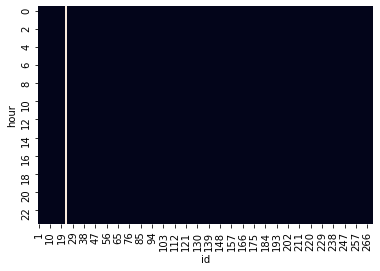

In [90]:
nulls = weekdays_pivot.copy()
sns.heatmap(nulls.isnull(), cbar=False)

<AxesSubplot:xlabel='id', ylabel='hour'>

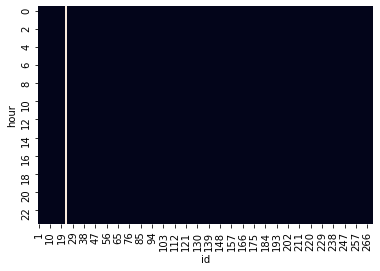

In [91]:
nulls = weekends_pivot.copy()
sns.heatmap(nulls.isnull(), cbar=False)

In [92]:
weekdays_pivot.iloc[0:5,20:25]

id,21,23,24,25,26
hour,,,,,
0,0.971052,0.021874,NaN,0.723229,0.659061
1,0.997979,0.302308,NaN,0.846323,0.793615
2,0.999361,0.205753,NaN,0.910169,0.891175
3,0.996857,0.314798,NaN,0.967802,0.945426
4,0.998612,0.365024,NaN,1.000000,0.973746


In [93]:
weekends_pivot.iloc[0:5,20:25]

id,21,23,24,25,26
hour,,,,,
0,0.971052,0.021874,NaN,0.723229,0.659061
1,0.997979,0.302308,NaN,0.846323,0.793615
2,0.999361,0.205753,NaN,0.910169,0.891175
3,0.996857,0.314798,NaN,0.967802,0.945426
4,0.998612,0.365024,NaN,1.000000,0.973746


In [94]:
filt = (uso["id"] == 24)
check = uso[filt]
print(check.head(5))
print("""
""")
print("Sum of free_bases: " f"{check.free_bases.sum()}")

                   date  id  free_bases  dock_bikes  day  hour
22  2018-08-01 01:00:00  24           0           0    2     1
194 2018-08-01 02:00:00  24           0           0    2     2
366 2018-08-01 03:00:00  24           0           0    2     3
538 2018-08-01 04:00:00  24           0           0    2     4
710 2018-08-01 05:00:00  24           0           0    2     5


Sum of free_bases: 0


In [95]:
weekdays_pivot.drop(24, axis=1, inplace=True) 
weekends_pivot.drop(24, axis=1, inplace=True)

******

# Visualización de las curvas de demanda.

### De lunes a viernes.

In [96]:
fig = go.Figure()

for station_name in weekdays_pivot.columns:
    fig.add_trace(go.Scatter(y=weekdays_pivot[station_name],
                    mode='lines',
                    name=station_name))
fig.show()

### De sabado a domingo.

In [97]:
fig = go.Figure()

for station_name in weekends_pivot.columns:
    fig.add_trace(go.Scatter(y=weekends_pivot[station_name],
                    mode='lines',
                    name=station_name))
fig.show()

****

# Redimensión para los modelos.

In [98]:
n_weekdays_pivot = to_time_series_dataset(weekdays_pivot.values.T)
n_weekends_pivot = to_time_series_dataset(weekends_pivot.values.T)

In [99]:
print(n_weekdays_pivot.shape)
print(n_weekends_pivot.shape)

(265, 24, 1)
(265, 24, 1)


*****

# Modelos. De lunes a viernes.

In [100]:
scores = []
for k in range(1, 20):
    model = TimeSeriesKMeans(n_clusters=k, metric='euclidean', verbose=False, n_jobs=-1, n_init=15, random_state=0)
    model.fit(n_weekdays_pivot)
    scores.append(model.inertia_)
    print(f'Inertia value for {k}: {scores[-1]}')

Inertia value for 1: 2.7584241466589647
Inertia value for 2: 1.0823622263256016
Inertia value for 3: 0.8746650597105609
Inertia value for 4: 0.7202450897260746
Inertia value for 5: 0.600974418587333
Inertia value for 6: 0.5471425708978215
Inertia value for 7: 0.5116596131242652
Inertia value for 8: 0.4806560694817216
Inertia value for 9: 0.4537075548525626
Inertia value for 10: 0.42769385840115554
Inertia value for 11: 0.41092228670410336
Inertia value for 12: 0.38563788355162776
Inertia value for 13: 0.37936644669302255
Inertia value for 14: 0.3604033901141545
Inertia value for 15: 0.34303232620893853
Inertia value for 16: 0.3399743195906252
Inertia value for 17: 0.3267100475110521
Inertia value for 18: 0.31239305023783487
Inertia value for 19: 0.3032463427976746


k-value: 4


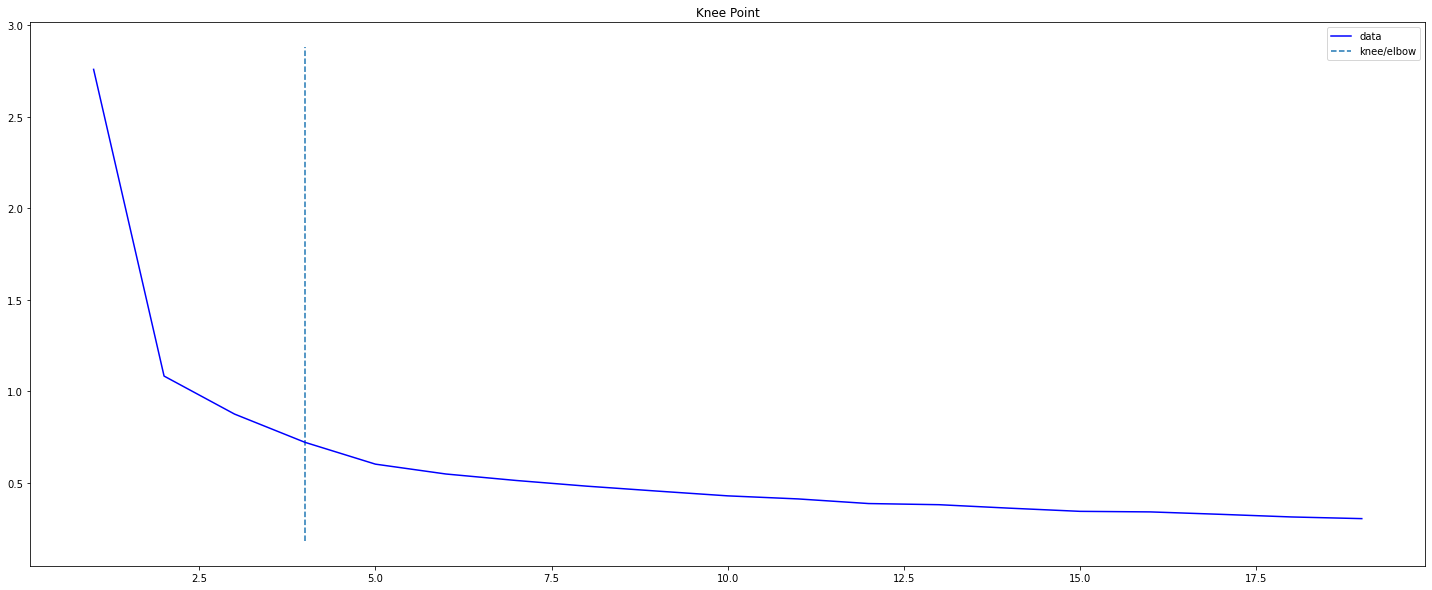

In [101]:
knee_locator = KneeLocator(range(1, len(scores)+1), scores, curve='convex', direction='decreasing', online=True)
knee_locator.plot_knee(figsize=(25,10))
print(f'k-value: {knee_locator.knee}')

### Euclidean Distance.

In [102]:
euclidean_model = TimeSeriesKMeans(n_clusters=knee_locator.knee, metric='euclidean', verbose=True, n_jobs=-1, random_state=0)
euclidean_cluster_labels = euclidean_model.fit_predict(n_weekdays_pivot)

0.985 --> 0.739 --> 0.729 --> 0.726 --> 0.725 --> 0.725 --> 


In [103]:
unique_label = np.unique(euclidean_cluster_labels)
fig = go.Figure()
default_state = "Cluster 1"
cluster_plot_names = []
buttons = []
states = []
for idx in range(len(unique_label)):
    for element_idx in np.argwhere(euclidean_cluster_labels == unique_label[idx]):
        fig.add_trace(go.Scatter(x=weekdays_pivot.iloc[:, element_idx].index, y=weekdays_pivot.iloc[:, element_idx].values.flatten(), name=int(weekdays_pivot.columns[element_idx][0]), line=dict(color="gray"), opacity=0.4, visible=(f'Cluster {idx+1}'== default_state)))
    fig.add_trace(go.Scatter(x=weekdays_pivot.iloc[:, element_idx].index, y=euclidean_model.cluster_centers_[unique_label[idx]].flatten(), name=f'Cluster {idx+1} Center', line=dict(color="cyan"), visible=(f'Cluster {idx+1}'== default_state)))
    cluster_plot_names.extend([f'Cluster {idx+1}']*(len(np.argwhere(euclidean_cluster_labels == unique_label[idx]))+1))

for i in range(len(unique_label)):
    states.append(f'Cluster {i+1}')
    buttons.append(dict(method='update',
                        label=f'Cluster {i+1}',
                        args = [{'visible': [f'Cluster {i+1}'==r for r in cluster_plot_names]}]))

fig.update_layout(title_text='K-Means with Euclidean', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_state), "showactive": True, "x": 0.5, "y": 1.15}])
fig.show()

In [104]:
cluster_dist = pd.DataFrame(euclidean_cluster_labels+1, columns=['Clusters']).value_counts().reset_index(name='Count')
fig = px.bar(cluster_dist, x='Clusters', y='Count')
fig.show()

In [105]:
clusters = euclidean_cluster_labels+1 
clusters

array([2, 2, 2, 1, 1, 4, 4, 4, 2, 1, 2, 1, 1, 1, 3, 1, 4, 1, 2, 2, 2, 4,
       4, 4, 3, 3, 3, 2, 1, 2, 2, 3, 4, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 2, 3, 4, 1, 2, 3, 3, 3, 2,
       3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 3, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 4, 3, 3, 3, 1, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 3, 3, 1, 2, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 3, 3, 1, 1, 3,
       2, 3, 1, 2, 1, 3, 2, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 3,
       1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 2, 4, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 3, 1, 2, 2, 1, 1, 2, 4, 2, 1, 2, 2, 4, 3, 3, 4, 4, 2, 2, 2,
       1])

In [106]:
estaciones_localizacion = pd.read_csv('estaciones.csv')
estaciones_localizacion = estaciones_localizacion[["id", "name", "latitude", "longitude"]]
estaciones_cluster = uso.groupby(['id']).agg({'free_bases': "mean"})
estaciones_cluster.drop(24, axis=0, inplace=True)
estaciones_cluster.reset_index(inplace=True)
estaciones_cluster = estaciones_cluster.assign(cluster = clusters)
estaciones_cluster = estaciones_cluster.rename(columns={"free_bases": "avg demand"}, errors="raise")

In [107]:
estaciones_cluster.head(5) #Pasar a Jaime

,id,avg demand,cluster
0,1,12.439459,2
1,2,9.838319,2
2,3,13.881633,2
3,4,7.332265,1
4,5,13.923300,1


In [108]:
estaciones_cluster.to_csv("weekdays_clusters.csv", index=False)

In [109]:
merge = estaciones_cluster.merge(estaciones_localizacion,on="id", how='left')
merge

,id,avg demand,cluster,name,latitude,longitude
0,1,12.439459,2,Puerta del Sol A,40.417214,-3.701834
1,2,9.838319,2,Puerta del Sol B,40.417001,-3.702421
2,3,13.881633,2,Miguel Moya,40.420589,-3.705842
3,4,7.332265,1,Plaza Conde Suchil,40.430294,-3.706917
4,5,13.923300,1,Malasaña,40.428552,-3.702587
...,...,...,...,...,...,...
260,266,19.746309,4,Ciudad Universitaria 1,40.443750,-3.726990
261,267,18.418121,2,Ciudad Universitaria 2,40.443420,-3.726930
262,268,12.639839,2,Facultad Biología,40.449120,-3.727310
263,269,12.806994,2,Facultad Derecho,40.451090,-3.729370


In [110]:
city = "Madrid"

locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España
[lat, long]: [40.4167047, -3.7035825]


In [111]:
x, y = "latitude", "longitude"
color = "cluster"
size = "avg demand"
popup = "name"
data = merge.copy()


lst_colors=["red","blue","orange", "green"]
lst_elements = sorted(list(merge[color].unique()))
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)

data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)

legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

map_

*******

# Modelos. De sabado a domingo.

In [112]:
scores = []
for k in range(1, 20):
    model = TimeSeriesKMeans(n_clusters=k, metric='euclidean', verbose=False, n_jobs=-1, n_init=15, random_state=0)
    model.fit(n_weekends_pivot)
    scores.append(model.inertia_)
    print(f'Inertia value for {k}: {scores[-1]}')

Inertia value for 1: 2.7584241466589647
Inertia value for 2: 1.0823622263256016
Inertia value for 3: 0.8746650597105609
Inertia value for 4: 0.7202450897260746
Inertia value for 5: 0.600974418587333
Inertia value for 6: 0.5471425708978215
Inertia value for 7: 0.5116596131242652
Inertia value for 8: 0.4806560694817216
Inertia value for 9: 0.4537075548525626
Inertia value for 10: 0.42769385840115554
Inertia value for 11: 0.41092228670410336
Inertia value for 12: 0.38563788355162776
Inertia value for 13: 0.37936644669302255
Inertia value for 14: 0.3604033901141545
Inertia value for 15: 0.34303232620893853
Inertia value for 16: 0.3399743195906252
Inertia value for 17: 0.3267100475110521
Inertia value for 18: 0.31239305023783487
Inertia value for 19: 0.3032463427976746


k-value: 4


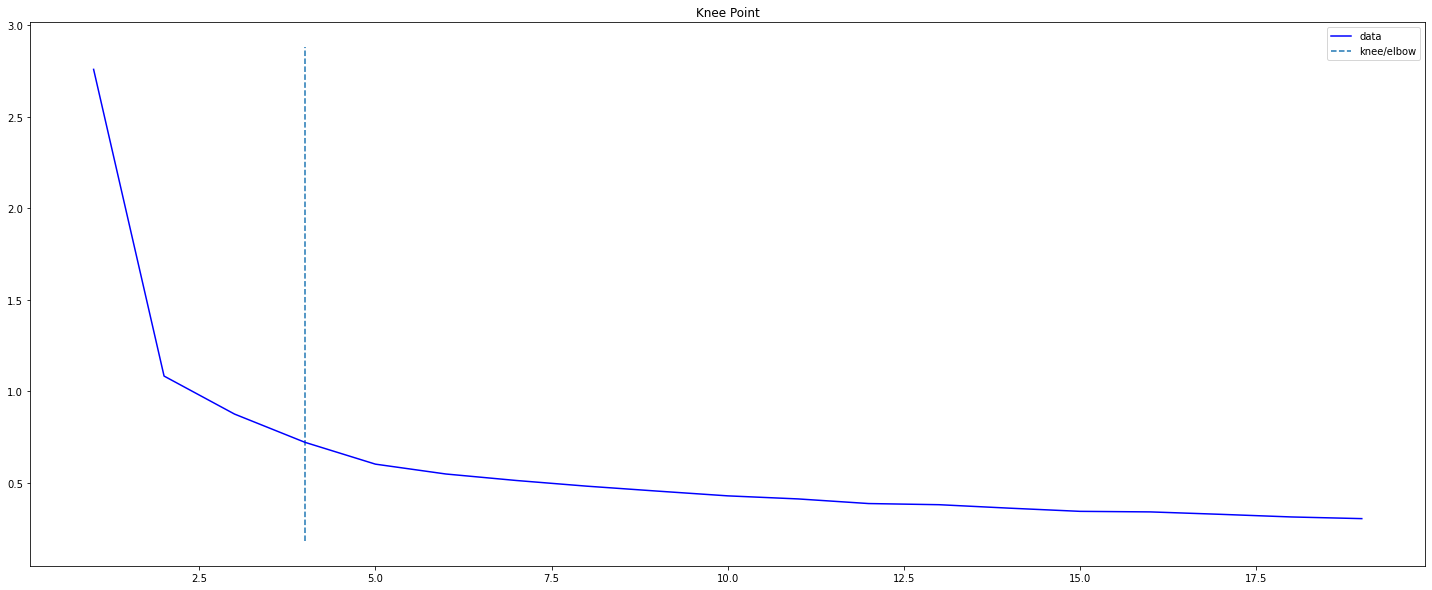

In [113]:
knee_locator = KneeLocator(range(1, len(scores)+1), scores, curve='convex', direction='decreasing', online=True)
knee_locator.plot_knee(figsize=(25,10))
print(f'k-value: {knee_locator.knee}')

In [114]:
euclidean_model = TimeSeriesKMeans(n_clusters=knee_locator.knee, metric='euclidean', verbose=True, n_jobs=-1, random_state=0)
euclidean_cluster_labels = euclidean_model.fit_predict(n_weekends_pivot)

0.985 --> 0.739 --> 0.729 --> 0.726 --> 0.725 --> 0.725 --> 


In [115]:
unique_label = np.unique(euclidean_cluster_labels)
fig = go.Figure()
default_state = "Cluster 1"
cluster_plot_names = []
buttons = []
states = []
for idx in range(len(unique_label)):
    for element_idx in np.argwhere(euclidean_cluster_labels == unique_label[idx]):
        fig.add_trace(go.Scatter(x=weekends_pivot.iloc[:, element_idx].index, y=weekends_pivot.iloc[:, element_idx].values.flatten(), name=int(weekdays_pivot.columns[element_idx][0]), line=dict(color="gray"), opacity=0.4, visible=(f'Cluster {idx+1}'== default_state)))
    fig.add_trace(go.Scatter(x=weekends_pivot.iloc[:, element_idx].index, y=euclidean_model.cluster_centers_[unique_label[idx]].flatten(), name=f'Cluster {idx+1} Center', line=dict(color="cyan"), visible=(f'Cluster {idx+1}'== default_state)))
    cluster_plot_names.extend([f'Cluster {idx+1}']*(len(np.argwhere(euclidean_cluster_labels == unique_label[idx]))+1))

for i in range(len(unique_label)):
    states.append(f'Cluster {i+1}')
    buttons.append(dict(method='update',
                        label=f'Cluster {i+1}',
                        args = [{'visible': [f'Cluster {i+1}'==r for r in cluster_plot_names]}]))

fig.update_layout(title_text='K-Means with Euclidean', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_state), "showactive": True, "x": 0.5, "y": 1.15}])
fig.show()

In [116]:
cluster_dist = pd.DataFrame(euclidean_cluster_labels+1, columns=['Clusters']).value_counts().reset_index(name='Count')
fig = px.bar(cluster_dist, x='Clusters', y='Count')
fig.show()

In [117]:
clusters = euclidean_cluster_labels+1 
clusters

array([2, 2, 2, 1, 1, 4, 4, 4, 2, 1, 2, 1, 1, 1, 3, 1, 4, 1, 2, 2, 2, 4,
       4, 4, 3, 3, 3, 2, 1, 2, 2, 3, 4, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 2, 3, 4, 1, 2, 3, 3, 3, 2,
       3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 3, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 4, 3, 3, 3, 1, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 3, 3, 1, 2, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 3, 3, 1, 1, 3,
       2, 3, 1, 2, 1, 3, 2, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 3,
       1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2, 2, 4, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 3, 1, 2, 2, 1, 1, 2, 4, 2, 1, 2, 2, 4, 3, 3, 4, 4, 2, 2, 2,
       1])

In [118]:
estaciones_cluster = uso.groupby(['id']).agg({'free_bases': "sum"})
estaciones_cluster.drop(24, axis=0, inplace=True)
estaciones_cluster.reset_index(inplace=True)
estaciones_cluster = estaciones_cluster.assign(cluster = clusters)
estaciones_cluster = estaciones_cluster.rename(columns={"free_bases": "avg demand"}, errors="raise")

In [119]:
estaciones_cluster.head(5)

,id,avg demand,cluster
0,1,279440,2
1,2,221008,2
2,3,311837,2
3,4,164712,1
4,5,312773,1


In [120]:
estaciones_cluster.to_csv("weekends_clusters.csv", index=False)